# A quick datahub analysis

I'm copy/pasting from your email with suggestions, and trying to show a few plots that get
at those suggestions below. Let me know what I'm missing!

In [30]:
import pandas as pd
from pathlib import Path
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [65]:
files = Path("./data/raw").glob("*.gz")
all_data = []
for ifile in files:
    data = pd.read_json(ifile, lines=True)
    data['hub'] = ifile.name.split('.')[0].replace("-events", "")
    all_data.append(data)
data = pd.concat(all_data)

In [66]:
# Clean it up
for col in data.columns:
    data = data.rename(columns={col: col.strip('_')})
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.tz_convert("US/Pacific")
data['id'] = pd.factorize(data['username'])[0]
data['date'] = data['timestamp'].dt.date

# Only keep start sessions for now
data = data.query("action == 'start'").reset_index(drop=True)

In [54]:
# Non-functioning code to try and pair start/stop events into sessions
# from tqdm import tqdm

# sessions = []
# for hub, idata in data.groupby('hub'):
#     hub_sessions = []
#     pending_sessions = {}
#     for ii, irow in tqdm(list(idata.iterrows())):
#         # If we hit a stop action, then we'll append this session to our sessions list
#         if irow["action"] == "stop":
#             if irow['id'] in pending_sessions:
#                 pending_sessions[irow['id']]['stop'] = irow['timestamp']
#                 hub_sessions.append(pending_sessions.pop(irow['id']))
#         # If we hit a start action, open up a spot for it in the pending_sessions to wait for the stop action to be found
#         else:
#             if irow['id'] not in pending_sessions:
#                 irow['start'] = irow['timestamp']
#                 for key in ['timestamp', 'action']:
#                     irow.pop(key)
#                 pending_sessions[irow['id']] = irow
#     sessions.append(hub_sessions)

## Total usage

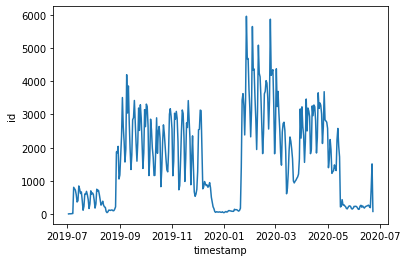

In [114]:
usage_daily = data.resample('D', on='timestamp').agg({'id': 'count'}).reset_index()
sns.lineplot(x='timestamp', y='id', data=usage_daily)

## Different definitions of 'users'

Most common are:

1. Total users served - anyone who has used it even once
2. Daily active users - users who have interacted with it at least once, each day
3. Monthly active users, users who have interacted with it at least once each month (or a 30d rolling window)

Tech spending *should* (but doesn't always) closely track with (2), while 'value provided' IMO more closely tracks with (3). I think (1) is a vanity metric that's cool to put on tweets though ;)

How we communicate this is extremely important. We need to show people we provide value, while at the same time being transparent, accurate & accountable.


In [85]:
unique_users = data.groupby('hub').nunique()['id'].reset_index()
unique_daily_users = data.groupby('hub').resample('D', on='timestamp').nunique()['id'].reset_index()
unique_weekly_users = data.groupby('hub').resample('W', on='timestamp').nunique()['id'].reset_index()
unique_monthly_users = data.groupby('hub').resample('M', on='timestamp').nunique()['id'].reset_index()

In [89]:
alt.Chart(unique_users, title="Users in each hub").mark_bar().encode(
    x='hub',
    y='id',
)

alt.Chart(...)

In [90]:
alt.Chart(unique_daily_users, title="Daily unique users per hub").mark_line().encode(
    x='timestamp',
    y='id',
    color='hub'
)

alt.Chart(...)

In [92]:
alt.Chart(unique_weekly_users, title="Weekly unique users per hub").mark_line().encode(
    x='timestamp',
    y='id',
    color='hub'
)

alt.Chart(...)

In [93]:
alt.Chart(unique_monthly_users, title="Monthly unique users per hub").mark_line().encode(
    x='timestamp',
    y='id',
    color='hub'
)

alt.Chart(...)

**Variability in weekly sessions across users**

In [123]:
# Variability in weekly sessions across users
weekly_user_activity = data.groupby(['id']).resample('W', on='timestamp')['username'].count()

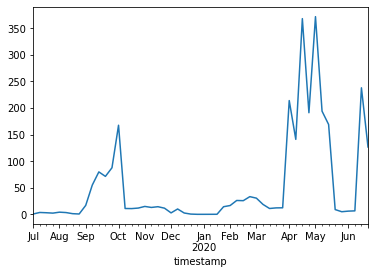

In [128]:
weekly_user_activity.groupby('timestamp').var().plot()

# User usage patterns

I'd hypothesize there are at least 3 kinds of users

1. Power users - TAs, folks writing curriculum, etc. Eric, Keeley, Chris Pyles. Although many of them might be using Jupyter more locally, so their session times may not be very high. But they'll be very consistently be on the platform, in non-uniform times
2. Regular class users. If you take data8 or data100, you're probably on all the time, but in predictable times, grouped with others who are taking the classes, with similarish session lengths / durations. This would also apply to smaller classes (like the public health one). We could possibly use this to detect which classes are using us? In conjunction with nbgitpuller data?
3. Long tail users. This is 'everyone else', stereotypically modules users. This is tremendous, hidden value add - many of these are folks who might not have done any computing otherwise. This is what's enabled by our very open gated policy. Having some sense of how many of these there are, and who they are, would be very helpful. This is the group most often shut out by policies (like UCSD's) that require you get explicit approval before you can use their resources. We deal with it instead by working on cost reduction, rather than gating.

I'm sure there are more, but I think just the 'user usage patterns' thing would make an extremely cool blog post :D

In [94]:
days_on_hub = data.groupby(['id', 'hub']).agg({'date': 'count'}).reset_index()
days_on_hub = days_on_hub.rename(columns={'date': 'days'})
days_on_hub['logdays'] = days_on_hub['days'].apply(np.log)

### Log number of days that students used a hub at least once

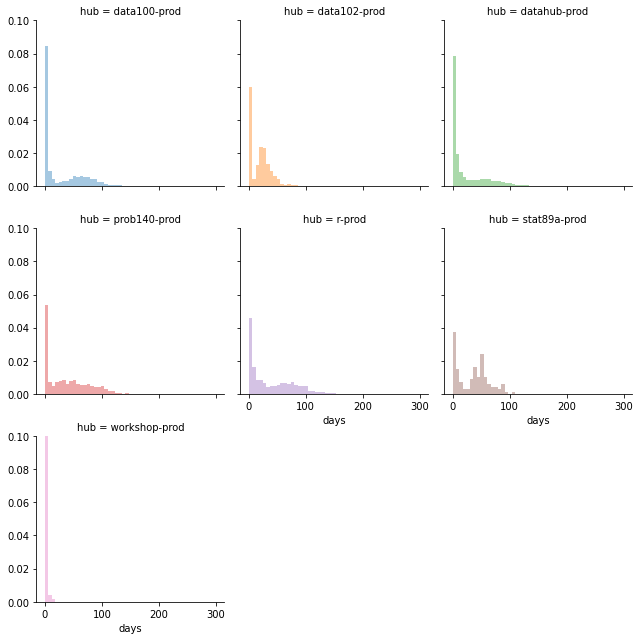

In [110]:
# How many days did each student show up on a hub
grid = sns.FacetGrid(days_on_hub, col='hub', hue='hub', col_wrap=3)
grid.map(sns.distplot, 'days', bins=np.linspace(0, 300, 50), kde=False, norm_hist=True)
grid.set(ylim=[0, .1])

In [111]:
# What times of day do users log on
data['hour'] = data['timestamp'].dt.hour
data['dayofweek'] = data['timestamp'].dt.day

### Hours of the day when students were using a hub

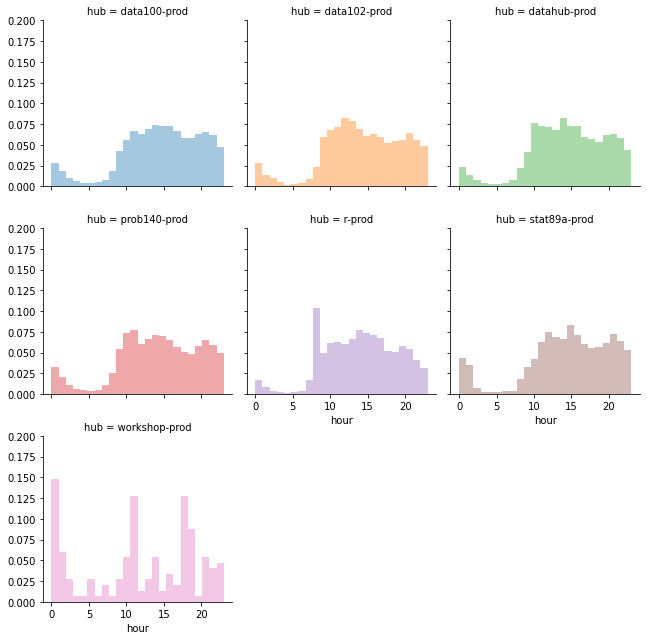

In [113]:
# How many days did each student show up on a hub
grid = sns.FacetGrid(data, col='hub', hue='hub', col_wrap=3)
grid.map(sns.distplot, 'hour', bins=24, kde=False, norm_hist=True)
grid.set(ylim=[0, .2])